<a href="https://colab.research.google.com/github/nedokormysh/GB_ML_business/blob/course_project/GB_ML_business_no_docker_server.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Домашнее задание
Стандартная версия Нужно реализовать rest api на базе flask в google colab.

выбрать себе датасет (который интересен или нравится больше всего, можно глянуть здесь https://economic-caper-a4c.notion.site/d062c410b90145bca90fc23b1348c813), сделать pipeline (преобразования + модель), сохранить его на диск. Если не хочется пайплайн, то можно без него, но так вам же будет удобнее потом вызывать его из кода сервиса.
Реализовать ноутбук с сервером
Реализовать ноутбук с клиентом
Сложная версия

Нужно реализовать rest api на базе flask (пример https://github.com/fimochka-sudo/GB_docker_flask_example)

выбрать себе датасет (который интересен или нравится больше всего, можно глянуть здесь https://economic-caper-a4c.notion.site/d062c410b90145bca90fc23b1348c813), сделать pipeline (преобразования + модель), сохранить его на диск. Если не хочется пайплайн, то можно без него, но так вам же будет удобнее потом вызывать его из кода сервиса.

для вашего проекта вам понадобится requirements.txt с пакетами. Можно за основу взять такой файл из проекта выше. Для его установки прям в pycharm можно открыть терминал и сделать pip install -r requirements.txt (находясь в корне проекта)

итоговый проект должен содержать:
каталог app/models/ (здесь модель-пайплайн предобученная либо код обучения модели-пайплайна)

файл app/run_server.py (здесь основной код flask-приложения)

requirements.txt (список пакетов, которые у вас используются в проекте - в корне проекта)

README.md (здесь какое-то описание, что вы делаете, что за данные, как запускать и т.д)

*Dockerfile

*docker-entrypoint.sh

*front-end сервис какой-то, который умеет принимать от пользователя введеные данные и ходить в ваш api. На самом деле полезно больше вам, т.к если ваш проект будет далее развиваться (новые модели, интересные подходы), то это хороший пунктик к резюме и в принципе - строчка в портфолио)

Возьмём датасет https://www.kaggle.com/datasets/arashnic/hr-analytics-job-change-of-data-scientists

# Step 1 - Train

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/nedokormysh/GB_ML_business/course_project/aug_train.csv', index_col='enrollee_id')
df.sort_index().head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
enrollee_id,,,,,,,,,,,,,
1,city_103,0.920,Male,No relevent experience,no_enrollment,High School,NaN,2,NaN,Pvt Ltd,never,150,0.0
2,city_103,0.920,Male,No relevent experience,no_enrollment,Phd,STEM,15,10000+,NGO,3,128,1.0
4,city_103,0.920,Male,No relevent experience,no_enrollment,Masters,STEM,9,50-99,Public Sector,>4,13,0.0
5,city_67,0.855,Male,Has relevent experience,no_enrollment,Masters,STEM,10,<10,Early Stage Startup,1,12,0.0
7,city_136,0.897,Male,Has relevent experience,Full time course,Masters,STEM,13,NaN,NaN,1,18,0.0


In [ ]:
df.shape

(19158, 13)

In [ ]:
X = df.iloc[:,:-1]
y = df['target']

In [ ]:
y.value_counts()

0.0    14381
1.0     4777
Name: target, dtype: int64

In [ ]:
def save(df, PATH):
    df.to_csv(PATH, index=False, encoding='utf-8', sep=';')

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, 
                                                    y, test_size=0.33, random_state=7575)

#save test
X_val.to_csv("X_test.csv", index=None)
y_val.to_csv("y_test.csv", index=None)
#save train
X_train.to_csv("X_train.csv", index=None)
y_train.to_csv("y_train.csv", index=None)

Text(0.5, 1.0, 'target')

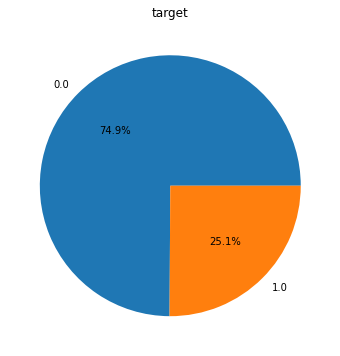

In [ ]:
labels = y_train.value_counts().index
sizes = y_train.value_counts().values

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('target')

In [ ]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f'Количество наблюдений в обучающей выборке: {y_train.count()}',
      f'Количество наблюдений в тестовой выборке: {y_val.count()}',
      f'Дисбаланс целевой переменной: {disbalance:.2f}', sep='\n')

Количество наблюдений в обучающей выборке: 12835
Количество наблюдений в тестовой выборке: 6323
Дисбаланс целевой переменной: 2.99


Рассмотрим чуть подробнее обучающую выборку.

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12835 entries, 948 to 20699
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    12835 non-null  object 
 1   city_development_index  12835 non-null  float64
 2   gender                  9841 non-null   object 
 3   relevent_experience     12835 non-null  object 
 4   enrolled_university     12585 non-null  object 
 5   education_level         12521 non-null  object 
 6   major_discipline        10923 non-null  object 
 7   experience              12803 non-null  object 
 8   company_size            8857 non-null   object 
 9   company_type            8708 non-null   object 
 10  last_new_job            12554 non-null  object 
 11  training_hours          12835 non-null  int64  
dtypes: float64(1), int64(1), object(10)
memory usage: 1.3+ MB


У нас есть пропущенные значения. Посмотрим какой процент пропусков от общего количества объектов.

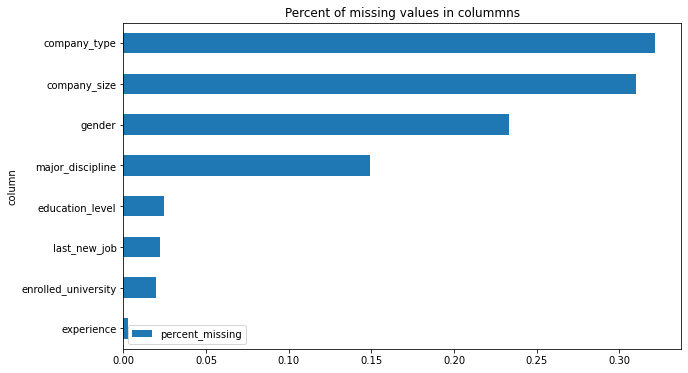

In [ ]:
def plot_missing_values(df):
    """ For each column with missing values plot proportion that is missing."""
    data = [(col, df[col].isnull().sum() / len(df)) 
            for col in df.columns if df[col].isnull().sum() > 0]
    col_names = ['column', 'percent_missing']
    missing_df = pd.DataFrame(data, columns=col_names).sort_values('percent_missing')
    pylab.rcParams['figure.figsize'] = (10, 6)
    missing_df.plot(kind='barh', x='column', y='percent_missing'); 
    plt.title('Percent of missing values in colummns');

plot_missing_values(X_train)

Начнём создавать пайплайн для обработки.

In [ ]:
cat_cols = [
            'city', 
            'gender', 'relevent_experience',
            'enrolled_university', 'education_level', 'major_discipline',
            'experience', 'company_size', 'company_type', 'last_new_job',]
cont_columns = ['city_development_index', 'training_hours']

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):        
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

class TextImputer(BaseEstimator, TransformerMixin):
    def __init__(self, key, value):
        self.key = key
        self.value = value
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X[self.key] = X[self.key].fillna(self.value)
        return X

class NaFiller(BaseEstimator, TransformerMixin):
    def __init__(self, key, mthd):
        self.key = key
        self.mthd = mthd        

    def fit(self, X, y=None):
        self.modes = X.mode()
        # self.medians = X.median()
        return self

    def transform(self, X):
        if self.mthd == 'Other':
          X[self.key].fillna('Other', inplace=True)
        # elif self.mthd == 'Median':
        #   X[self.key].fillna(self.medians[self.key], inplace=True)
        elif self.mthd == 'Mode':
          X[self.key].fillna(self.modes[self.key][0], inplace=True)  
        return X

In [ ]:
X_train.columns

Index(['city', 'city_development_index', 'gender', 'relevent_experience',
       'enrolled_university', 'education_level', 'major_discipline',
       'experience', 'company_size', 'company_type', 'last_new_job',
       'training_hours'],
      dtype='object')

In [ ]:
# X = df.iloc[:,:-1]
# y = df['target']

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=7575)

# cat_cols = [
#             'city', 
#             'gender', 'relevent_experience',
#             'enrolled_university', 'education_level', 'major_discipline',
#             'experience', 'company_size', 'company_type', 'last_new_job',]

# cont_columns = ['city_development_index', 'training_hours']

# 1
city = Pipeline([
                ('selector', FeatureSelector(column='city')),
                ('ohe', OHEEncoder(key='city'))
                 ])
# 2
city_development_index = Pipeline([
                ('selector', NumberSelector(key='city_development_index')),
                ('scaler', StandardScaler())
                ])
# 3
gender =  Pipeline([                 
                   ('fill', NaFiller(key='gender', mthd='Other')),
                   ('selector', FeatureSelector(column='gender')),
                   ('ohe', OHEEncoder(key='gender'))
                   ])
# 4
relevent_experience =  Pipeline([                 
                ('fill', NaFiller(key='relevent_experience', mthd='Mode')),
                ('selector', FeatureSelector(column='relevent_experience')),
                ('ohe', OHEEncoder(key='relevent_experience'))
                ])
# 5
enrolled_university =  Pipeline([                 
                ('fill', NaFiller(key='enrolled_university', mthd='Mode')),
                ('selector', FeatureSelector(column='enrolled_university')),
                ('ohe', OHEEncoder(key='enrolled_university'))
                ])
# 5
education_level = Pipeline([                 
                ('fill', NaFiller(key='education_level', mthd='Mode')),
                ('selector', FeatureSelector(column='education_level')),
                ('ohe', OHEEncoder(key='education_level'))
                ])
# 6
major_discipline = Pipeline([                 
                ('fill', NaFiller(key='major_discipline', mthd='Mode')),
                ('selector', FeatureSelector(column='major_discipline')),
                ('ohe', OHEEncoder(key='major_discipline'))
                ])
# 7
experience = Pipeline([                 
                ('fill', NaFiller(key='experience', mthd='Other')),
                ('selector', FeatureSelector(column='experience')),
                ('ohe', OHEEncoder(key='experience'))
            ])
# 8
company_size =  Pipeline([                 
                ('fill', NaFiller(key='company_size', mthd='Other')),
                ('selector', FeatureSelector(column='company_size')),
                ('ohe', OHEEncoder(key='company_size'))
            ])
# 9
company_type =  Pipeline([                 
                ('fill', NaFiller(key='company_type', mthd='Other')),
                ('selector', FeatureSelector(column='company_type')),
                ('ohe', OHEEncoder(key='company_type'))
            ])
# 10
last_new_job = Pipeline([                 
                ('fill', NaFiller(key='last_new_job', mthd='Mode')),
                ('selector', FeatureSelector(column='last_new_job')),
                ('ohe', OHEEncoder(key='last_new_job'))
            ])

# 11

training_hours = Pipeline([
                ('selector', NumberSelector(key='training_hours')),
                ('scaler', StandardScaler())
                ])

feats = FeatureUnion([
                      ('city', city),
                      ('city_development_index', city_development_index),
                      ('gender', gender),
                      ('relevent_experience', relevent_experience),
                      ('enrolled_university', enrolled_university),
                      ('education_level', education_level),
                      ('major_discipline', major_discipline),
                      ('experience', experience),
                      ('company_size', company_size),
                      ('company_type', company_type),
                      ('last_new_job', last_new_job),
                      ('training_hours', training_hours),
                      ])

In [ ]:
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit(X_train)

feature_processing.transform(X_train)
feature_processing.transform(X_val)

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.98900213],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.        , -0.17426574],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.1410112 ],
       ...,
       [ 0.        ,  1.        ,  0.        , ...,  1.        ,
         0.        ,  2.33645253],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.88923849],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.49018394]])

In [ ]:
classifier = Pipeline([
    ('features', feats),
    ('classifier', xgb.XGBClassifier(random_state=7575, verbose=False)),
])
# classifier.fit(X_train, y_train)

# запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=5, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print(f'CV score is {cv_score}+-{cv_score_std}')

# обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
# y_score = classifier.predict_proba(X_val)[:, 1]

CV score is 0.7964631318171982+-0.006676120147210287


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('city',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='city')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='city'))])),
                                                ('city_development_index',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='city_development_index')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('gender',
                                                 Pipeline(steps=[('fill',
       

In [ ]:
classifier.steps

[('features', FeatureUnion(transformer_list=[('city',
                                  Pipeline(steps=[('selector',
                                                   FeatureSelector(column='city')),
                                                  ('ohe',
                                                   OHEEncoder(key='city'))])),
                                 ('city_development_index',
                                  Pipeline(steps=[('selector',
                                                   NumberSelector(key='city_development_index')),
                                                  ('scaler', StandardScaler())])),
                                 ('gender',
                                  Pipeline(steps=[('fill',
                                                   NaFiller(key='gender',
                                                            mthd='Other')),
                                                  ('selector',
                                          

In [ ]:
import dill

with open("./xgb_simple.dill", "wb") as f:
    dill.dump(classifier, f)

# Step 2 - PREDICT

### Проверка работоспособности и качества пайплайна

Здесь мы еще не запускаем никакое API, а загружаем модель (pipeline) напрямую и проверяем на отложенной (тестовой) выборке

In [ ]:
X_val = pd.read_csv("X_test.csv")
y_val = pd.read_csv("y_test.csv")

In [ ]:
X_val.head(3)

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,city_103,0.920,NaN,No relevent experience,no_enrollment,High School,NaN,<1,NaN,NaN,NaN,6
1,city_21,0.624,Female,No relevent experience,Full time course,High School,NaN,3,NaN,NaN,never,55
2,city_103,0.920,NaN,No relevent experience,no_enrollment,High School,NaN,<1,NaN,NaN,NaN,57


In [ ]:
with open('./xgb_simple.dill', 'rb') as in_strm:
    pipeline = dill.load(in_strm)

In [ ]:
pipeline

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('city',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='city')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='city'))])),
                                                ('city_development_index',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='city_development_index')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('gender',
                                                 Pipeline(steps=[('fill',
       

In [ ]:
y_score = pipeline.predict_proba(X_val)[:, 1]

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_val, y_score)

0.8048458479849911

In [ ]:
y_score[:10]

array([0.33687592, 0.52445257, 0.4306485 , 0.08347196, 0.05136942,
       0.07990615, 0.07718179, 0.67136866, 0.6257013 , 0.65298605],
      dtype=float32)

# Step 3 - FLASK

In [ ]:
!pip install flask-ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from flask_ngrok import run_with_ngrok
from flask import Flask, request, jsonify
# import flask
import pandas as pd

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.tgz
!tar -xvf /content/ngrok-stable-linux-amd64.tgz
!./ngrok authtoken 2M9XeivGDMhn2CPAbeA8uL0zfoE_7v6Bam2k8eDQyFG9YmaQk
!./ngrok http 80

--2023-02-23 22:25:03--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.tgz
Resolving bin.equinox.io (bin.equinox.io)... 54.161.241.46, 18.205.222.128, 52.202.168.65, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.161.241.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13856790 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.tgz.5’

ngrok-stable-linux- 100%[===================>]  13.21M  35.4MB/s    in 0.4s    

2023-02-23 22:25:03 (35.4 MB/s) - ‘ngrok-stable-linux-amd64.tgz.5’ saved [13856790/13856790]

ngrok
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
import pandas as pd
import dill
import os

### **Создаем сервис для обработки запросов к модели**

In [ ]:
# Загружаем обученные модели
with open('./xgb_simple.dill', 'rb') as in_strm:
    pipeline = dill.load(in_strm)

In [ ]:
X_val = pd.read_csv("X_test.csv")
y_val = pd.read_csv("y_test.csv")

Запустить сервис и не глушить его, пока работаем 

In [ ]:
# Обработчики и запуск Flask
app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when app is run


@app.route("/", methods=["GET"])
def general():
    return "Welcome to prediction process"

@app.route('/predict', methods=['POST'])
def predict():
    data = {"success": False}

    # ensure an image was properly uploaded to our endpoint
    city, city_development_index, gender, relevent_experience, enrolled_university, education_level, major_discipline, experience, company_size, company_type, last_new_job, training_hours = "", "", "", "", "", "", "", "", "", "", "", ""
    request_json = request.get_json()
    
    # print(request_json)

    if request_json["city"]:
      city = request_json['city']

    if request_json["city_development_index"]:
      city_development_index = request_json['city_development_index']

    if request_json["gender"]:
      gender = request_json['gender']
    
    if request_json["relevent_experience"]:
      relevent_experience = request_json['relevent_experience']

    if request_json["enrolled_university"]:
      enrolled_university = request_json['enrolled_university']
    
    if request_json["education_level"]:
      education_level = request_json['education_level']    

    if request_json["major_discipline"]:
      major_discipline = request_json['major_discipline']

    if request_json["experience"]:
      experience = request_json['experience']

    if request_json["company_size"]:
      company_size = request_json['company_size']

    if request_json["company_type"]:
      company_type = request_json['company_type']

    if request_json["last_new_job"]:
      last_new_job = request_json['last_new_job']

    if request_json["training_hours"]:
      training_hours = request_json['training_hours']
    
    print(city, education_level)
    print('First Step Ok')  
    # preds = model.predict_proba(pd.DataFrame({
    #         'city': city, 
    #         'city_development_index': city_development_index,
    #         'gender': gender,
    #         'relevent_experience': relevent_experience,
    #         'enrolled_university': enrolled_university,
    #         'education_level': education_level,
    #         'major_discipline': major_discipline,
    #         'experience': experience,
    #         'company_size': company_size,
    #         'company_type': company_type,
    #         'last_new_job': last_new_job,
    #         'training_hours': training_hours,}))
    
    df_r = pd.DataFrame({"city": [city],
                       "city_development_index": [city_development_index],
                       "gender": [gender],
                       "relevent_experience": [relevent_experience],
                       "enrolled_university": [enrolled_university],
                       "education_level": [education_level],
                       "major_discipline": [major_discipline],
                       "experience": [experience],
                       "company_size": [company_size],
                       "company_type": [company_type],
                       "last_new_job": [last_new_job],
                       "training_hours": [training_hours], })
    
    preds = model.predict_proba(df_r)
    print(preds, 'Sekond step is OK')
    data["predictions"] = str(preds[:, 1][0])
    data["relevent_experience"] = relevent_experience
        # indicate that the request was a success
    data["success"] = True

    print('OK')
    print(data)

        # return the data dictionary as a JSON response
    print(jsonify(data))
    return jsonify(data)


if __name__ == '__main__':
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://f69e-35-245-59-110.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:01:30] "POST /predict HTTP/1.1" 200 -


city_136 Masters
First Step Ok
[[0.92009383 0.07990615]] Sekond step is OK
OK
{'success': True, 'predictions': '0.07990615', 'relevent_experience': 'No relevent experience'}
<Response 91 bytes [200 OK]>


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:02:31] "POST /predict HTTP/1.1" 200 -


city_136 Masters
First Step Ok
[[0.91269886 0.08730111]] Sekond step is OK
OK
{'success': True, 'predictions': '0.08730111', 'relevent_experience': 'No relevent experience'}
<Response 91 bytes [200 OK]>


In [ ]:
# Обработчики и запуск Flask
app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when app is run

def load_model(model_path):
  # load the pre-trained model
  global model
  with open(model_path, 'rb') as f:
    model = dill.load(f)
	# print(model)

modelpath = "./xgb_simple.dill"
load_model(modelpath)

@app.route("/", methods=["GET"])
def general():
  return """Welcome to job change prediction process. Please use 'http://<address>/predict' to POST"""

@app.route("/predict", methods=["POST"])
def predict():
  data = {"success": False}
	# dt = strftime("[%Y-%b-%d %H:%M:%S]")
	# ensure an image was properly uploaded to our endpoint
  # if flask.request.method == "POST":
  city, city_development_index, gender, relevent_experience, enrolled_university, education_level, major_discipline, experience, company_size, company_type, last_new_job, training_hours = "", "", "", "", "", "", "", "", "", "", "", ""

  request_json = request.get_json()
    # print(request_json)
  if request_json["city"]:
      city = request_json['city']

  if request_json["city_development_index"]:
      city_development_index = request_json['city_development_index']

  if request_json["gender"]:
      gender = request_json['gender']
    
  if request_json["relevent_experience"]:
      relevent_experience = request_json['relevent_experience']

  if request_json["enrolled_university"]:
      enrolled_university = request_json['enrolled_university']
    
  if request_json["education_level"]:
      education_level = request_json['education_level']    

  if request_json["major_discipline"]:
      major_discipline = request_json['major_discipline']

  if request_json["experience"]:
      experience = request_json['experience']

  if request_json["company_size"]:
      company_size = request_json['company_size']

  if request_json["company_type"]:
      company_type = request_json['company_type']

  if request_json["last_new_job"]:
      last_new_job = request_json['last_new_job']

  if request_json["training_hours"]:
      training_hours = request_json['training_hours']

  df_r = pd.DataFrame({"city": [city],
                       "city_development_index": [city_development_index],
                       "gender": [gender],
                       "relevent_experience": [relevent_experience],
                       "enrolled_university": [enrolled_university],
                       "education_level": [education_level],
                       "major_discipline": [major_discipline],
                       "experience": [experience],
                       "company_size": [company_size],
                       "company_type": [company_type],
                       "last_new_job": [last_new_job],
                       "training_hours": [training_hours], })
  # print(df_r)

  try:
      preds = model.predict_proba(df_r)
      # print(preds)
  except AttributeError as e:
			# logger.warning(f'{dt} Exception: {str(e)}')
      data['predictions'] = str(e)
      data['success'] = False
      return jsonify(data)
		
  data["predictions"] = str(preds[:, 1][0])
  # print(data["predictions"])
    # indicate that the request was a success
  data["success"] = True

  print('OK')
  
  return jsonify(data)


# if this is the main thread of execution first load the model and
# then start the server
if __name__ == "__main__":
  app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://8cd2-35-245-59-110.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:48:50] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:03] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:11] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:11] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:12] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:12] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:12] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:12] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:13] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:13] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:13] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:14] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:14] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:14] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:14] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:15] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:15] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:15] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:16] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:16] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:16] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:16] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:17] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:17] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:17] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:17] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:18] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:18] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:18] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:19] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:19] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:19] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:20] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:20] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:20] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:20] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:21] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:21] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:21] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:22] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:22] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:22] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:23] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:23] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:23] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:23] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:24] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:24] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:24] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:25] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:25] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:25] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:25] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:26] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:26] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:26] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:27] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:27] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:27] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:27] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:28] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:28] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:28] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:28] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:29] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:29] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:29] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:30] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:30] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:30] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:30] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:31] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:31] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:31] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:32] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:32] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:32] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:32] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:33] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:33] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:33] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:34] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:34] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:34] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:35] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:35] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:35] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:35] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:36] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:36] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:36] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:37] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:37] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:37] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:37] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:38] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:38] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:38] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:39] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:39] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:39] "POST /predict HTTP/1.1" 200 -


OK


<ipython-input-169-2633b53612dd>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
INFO:werkzeug:127.0.0.1 - - [23/Feb/2023 23:49:39] "POST /predict HTTP/1.1" 200 -


OK
